## (실습)  Vision Transformer Fine-Tuning - cifar10
- 목표
 1. ViT code 이해
 2. pretrain 모델(ViT-b16) 이용 imagenet 1000 classes classification 실습
 3. pretrain 모델(ViT-b16) 이용 small dataset(cifar10)에서 fine-tuning 실습

- References 
  1. [vit-keras](https://github.com/faustomorales/vit-keras)
  1. [pretrained models](https://github.com/faustomorales/vit-keras/releases/)
  1. [vit-cifar10 code](https://github.com/kentaroy47/vision-transformers-cifar10)


Use vit-keras package

## Usage
Install vit-keras package using 
`pip install vit-keras --user`


[//]: # (`pip install vit-keras tensorflow-addons tensorflow-addons --user`)

In [ ]:
# try install in terminal 
# !pip3 install vit-keras --user
# !pip3 install tensorflow-addons --user

In [5]:
from PIL import Image

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Flatten, Dropout, Activation, Input
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.datasets import cifar10
from keras import initializers

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import time
import numpy as np

from vit_keras import vit, utils, visualize

In [6]:
import sys  # 'linux', 'win32'
import os #'nt','posix'
if sys.platform == 'linux': # mlp
    # in order to download models from huggingface in the ML Platform, it is necessary to set the following proxy and ssl 
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context
    # suwon
    import os
    os.environ['REQUESTS_CA_BUNDLE'] = '/etc/ssl/certs/ca-certificates.crt'
    os.environ['HTTP_PROXY'] ='http://75.17.107.42:8080'
    os.environ['HTTPS_PROXY'] ='http://75.17.107.42:8080'
elif sys.platform == 'win32':
    os.environ["PATH"]+= os.pathsep+"C:\\Program Files\\Graphviz\\bin"

## 1. ImageNet 1000 Classes Classification 

### Downloading pre-trained Weights

- ViT-B16 
 * patch size = 16
 * input image_size = 224
 * Transformer-encoder configurations 
| |L(num_layers)| H(heads) | D(hidden size)| d_mlp (MLP Size) | params |
|--|--|--|--|--|--|
| Base |12|12|768|3072| 86M |
| Large |24|16|1024|4096| 307M |

- Classification Head
  * Representation Layer : 본 실험에서는 사용 안함. imagenet21k weight 사용시 로드됨
                           (vit-keras code 참조)
- dropout = 0.1

In [7]:
# image_size = 244 if b16 or b32 and 384 if l16 or l32
image_size = 224 # or 384

classes = utils.get_imagenet_classes()
model = vit.vit_b16(
    image_size=image_size,
    activation='softmax', 
    pretrained=True,
    include_top=True,
    pretrained_top=True
)

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape_1 (Reshape)         (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      

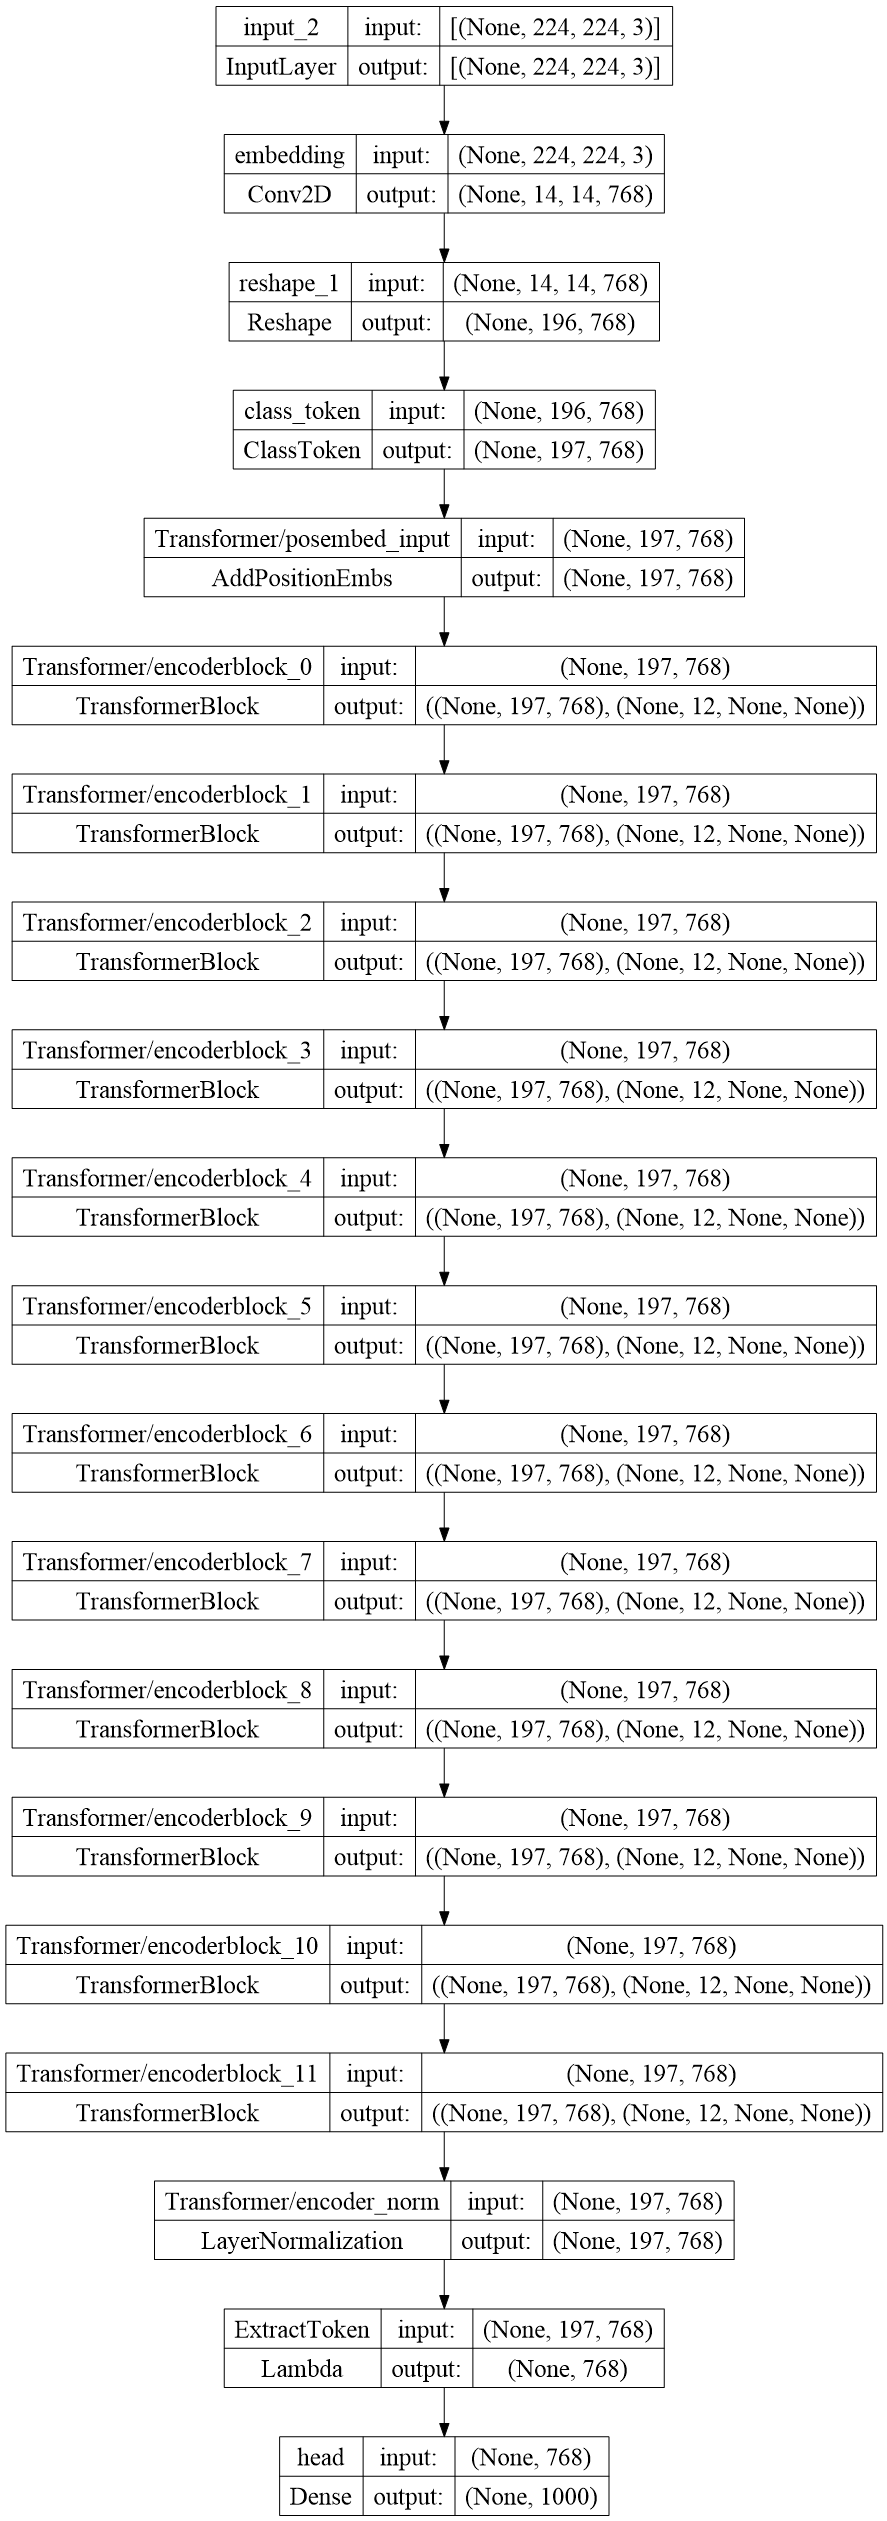

In [8]:
model.summary()
keras.utils.plot_model(model, to_file="vit-b16-in1k.png", show_shapes=True )

In [9]:
# ./image 내 파일을 보고 싶으면, 아래줄 uncomment 해서 실행해서 test image를 살펴보세요
# !ls ./images

In [10]:
# blocked in MLP에서는 외부 site 일부는 block되어 접근이 되지 않습니다.
# 아래와 같이 바로 접근되는 site에 대해서 image 로드하여 classification 실습을 해 볼 수 있습니다.
# url = 'https://d1bg8rd1h4dvdb.cloudfront.net/img/storypick/monamipet/2019/01/1811_pet_dog_pomeranian_m_01.jpg'

# local storage에 저장된 file로 먼저 실습을 진행해 봅시다.
image_path = './images/'
url1 = image_path + 'Granny_smith_and_cross_section.jpg'
url2 = image_path + 'Free!_(3987584939).jpg'
url = url1

image = utils.read(url, image_size)
X = vit.preprocess_inputs(image).reshape(1, image_size, image_size, 3) # to batch [1, H, W, C]
y = model.predict(X)
print(f'imagenet_class[{y[0].argmax()}] = ',classes[y[0].argmax()]) # Granny smith

1/1 [==============================] - 6s 6s/step
imagenet_class[948] =  Granny Smith


(-0.5, 223.5, 223.5, -0.5)

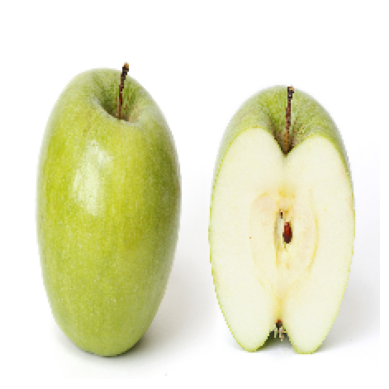

In [11]:
plt.imshow(image); plt.axis('off')  # uncomment if you want to see the input image

In [12]:
# sometime does not work (check storage or network connections)

# imagenet validation dataset
# https://github.com/ndb796/Small-ImageNet-Validation-Dataset-1000-Classes/tree/main/ILSVRC2012_img_val_subset

#url = 'https://github.com/ndb796/Small-ImageNet-Validation-Dataset-1000-Classes/blob/main/ILSVRC2012_img_val_subset/0/ILSVRC2012_val_00000293.JPEG?raw=true'
url = 'https://github.com/ndb796/Small-ImageNet-Validation-Dataset-1000-Classes/blob/main/ILSVRC2012_img_val_subset/100/ILSVRC2012_val_00000466.JPEG?raw=true'
image = utils.read(url, image_size)
X = vit.preprocess_inputs(image).reshape(1, image_size, image_size, 3)
y = model.predict(X)
print(f'imagenet_class[{y[0].argmax()}] = ',classes[y[0].argmax()]) 

1/1 [==============================] - 0s 150ms/step
imagenet_class[100] =  black swan, Cygnus atratus


## Visualize attention map

1/1 [==============================] - 0s 118ms/step
Prediction: black swan, Cygnus atratus


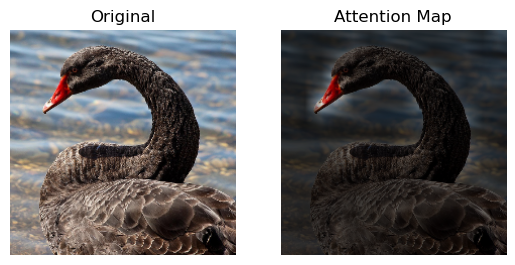

In [13]:
attention_map = visualize.attention_map(model=model, image=image)
print('Prediction:', classes[
    model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()]
)  # Prediction: Eskimo dog, husky

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

## 2. Fine-tuning using a ViT-B16 model 

### ViT-B16 
  - patch_size = 16, image_size = 224
  - paramters: 81MB (85,844,736 B)

In [14]:
seed = 2024
np.random.seed(seed)
tf.random.set_seed(seed)

## 2.1 Data Preparation
## Load Cifar10 dataset

In [15]:
(x_train_data, y_train_label), (x_test_data, y_test_label) = cifar10.load_data()
x_train_data = (x_train_data/255.).astype("float32")
x_test_data = (x_test_data/255.).astype("float32")
y_train_label = to_categorical(y_train_label)
y_test_label = to_categorical(y_test_label)

In [16]:
y_test_label.shape

(10000, 10)

In [17]:
# train dataset을 train(75%, 37,500)과 valid set(25%, 12,500)으로 나누기 (default=75%:25%)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_data, y_train_label, 
                                                      random_state=seed, shuffle=True)
# train:valid:test = 62.5%: 20.8%: 16.7%= 37,500:12,500: 10,000 (images)
x_test = x_test_data
y_test = y_test_label

In [18]:
x_train_data.shape,x_test_data.shape, x_train.shape, x_valid.shape, x_test.shape

((50000, 32, 32, 3),
 (10000, 32, 32, 3),
 (37500, 32, 32, 3),
 (12500, 32, 32, 3),
 (10000, 32, 32, 3))

In [19]:
x_train.shape[0]/x_train_data.shape[0] # = 375/500

0.75

In [20]:
# train, val, test ratio
dataset_ratio = np.array([x_train.shape[0], x_valid.shape[0], x_test.shape[0]])/(x_train_data.shape[0]+x_test.shape[0])
# np.array([37500, 12500, 10000])/60000
print(f'train:val:test={dataset_ratio[0]:.3f}:{dataset_ratio[1]:.3f}:{dataset_ratio[2]:.3f}')

train:val:test=0.625:0.208:0.167


### Makes data augmentation generator

In [21]:
batch_size = 32
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, zoom_range=0.2, 
                             horizontal_flip=True)
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

## 2.2 Modeling using ViT

**NOTE** 
- Resize input image: 32x32x3 --> 224x224x3
- Resize using tf `tf.image.resize`
- Fine-tuning : 2 steps (5m + 40~50m, 98%)

In [22]:
input_shape = (32, 32, 3) # Cifar10 image size
image_size = 224          # size after resizing image
num_classes = 10
model_type='vit_b16'

def build_model():
    inputs = Input(shape=input_shape)
    x = keras.layers.Lambda(
            lambda image: tf.image.resize(image, (image_size, image_size))
            )(inputs) # Resize image to  size 224x224
    
    base_model = vit.vit_b16(image_size=image_size, pretrained=True,
                             include_top=False, pretrained_top=False, 
                             activation="softmax" # not used if include_top=False
                            )
    base_model.trainable = False # Set false for transfer learning
    
    x = base_model(x) # x(output): 768
    x = Dense(32)(x) # activation=None(Default): 'Linear'
    # gelu activation, 'feature' layer naming
    x = Activation(keras.activations.gelu, name='feature')(x) # feature vector layer 이름 남김
    outputs = Dense(num_classes, activation="softmax")(x)

    model_final = Model(inputs=inputs, outputs=outputs)
    return model_final, base_model

#### Step1: Train only top layer

In [23]:
model, base_model = build_model()
model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), 
              loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()
print("\n")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                                 
 feature (Activation)        (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 85,823,594
Trainable params: 24,938
Non-train

In [24]:
base_model.summary()

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape_2 (Reshape)         (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      

## 2.3 Train the model

In [25]:
x_train.shape[0]/batch_size # 37500/32 == 1171.8 steps/epoch: steps_per_epoch 너무 크다

1171.875

In [26]:
start_time = time.time()
history1 = model.fit(train_generator,
          steps_per_epoch=200, # you can delete this parameter to achieve more accuracy, 
                               # but takes much time.
          epochs=2, 
          validation_data=(x_valid, y_valid),
         )
end_time = time.time()
print(f"training time = {end_time-start_time:.2f} sec") # ~ 330 sec

Epoch 1/2
200/200 [==============================] - 107s 480ms/step - loss: 0.9316 - accuracy: 0.6744 - val_loss: 0.4182 - val_accuracy: 0.8573
Epoch 2/2
200/200 [==============================] - 93s 468ms/step - loss: 0.6308 - accuracy: 0.7822 - val_loss: 0.3935 - val_accuracy: 0.8646
training time = 200.32 sec


#### Step 2:Train entire layers again (Fine tuning step)
- Info 
  * training time: 2-3 min/2 epoch 

In [27]:
#Set training callbacks
# ReduceLROnPlateau: 
# reduce learning rate by a factor of 2-10 once learning stagnates
# monitor: 기준이 되는 값, val_loss가 더이상 감소되지 않을 경우
# factor: learning rate 감소량, learning_rate *= factor 
# patient: Training이 진행됨에도 더이상 monitor되는 값의 개선이 없을 경우, 
#          최적의 monitor 값을 기준으로 몇 번의 epoch을 진행하고, 
#          learning rate를 조절할 지의 값
# verbose: 1(Early stopping 적용시 화명에 적용 메시지 나타남) or 0(화면 메시지 없이 종료)
# mode : "auto", "min"(loss), "max"(accuracy)
#      : monitor가 최소가 좋은지 최대가 좋은지 
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)

# EarlyStopping
# Stop training when a monitored metric has stopped improving.
# A model.fit() training loop will check at end of every epoch 
# whether the loss is no longer decreasing,
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

# Switch ViT layer to trainable for fine tuning
for layer in model.layers:
    layer.trainable = True    

In [28]:
# Requires compile again to activate trainable=True
model.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9), 
              loss="categorical_crossentropy", metrics=["accuracy"])

In [29]:
print("\n")
start_time = time.time()
history = model.fit(train_generator,
                    steps_per_epoch=200, #you can delete this parameter to achieve more accuracy, 
                                         # but takes much time.
                    epochs=10,
                    validation_data=(x_valid, y_valid),
                    callbacks=[plateau, earlystopping]
                   )
end_time = time.time()
print(f"training time = {end_time-start_time:.2f} sec") # > 40 min



Epoch 1/10
200/200 [==============================] - 156s 712ms/step - loss: 0.2970 - accuracy: 0.9069 - val_loss: 0.1304 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 2/10
200/200 [==============================] - 140s 699ms/step - loss: 0.2061 - accuracy: 0.9362 - val_loss: 0.1010 - val_accuracy: 0.9683 - lr: 0.0010
Epoch 3/10
200/200 [==============================] - 140s 700ms/step - loss: 0.1885 - accuracy: 0.9420 - val_loss: 0.0840 - val_accuracy: 0.9746 - lr: 0.0010
Epoch 4/10
200/200 [==============================] - 141s 704ms/step - loss: 0.1513 - accuracy: 0.9528 - val_loss: 0.0771 - val_accuracy: 0.9757 - lr: 0.0010
Epoch 5/10
200/200 [==============================] - 141s 709ms/step - loss: 0.1337 - accuracy: 0.9555 - val_loss: 0.0666 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 6/10
200/200 [==============================] - ETA: 0s - loss: 0.1422 - accuracy: 0.9537
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
200/200 [======================

## Plot the train history

In [30]:
def plot_history(history): 
    fig, ax = plt.subplots(figsize=(20, 9), nrows=1, ncols=2)
    ax[0].plot(history.history["loss"], c="r", label="train loss")
    ax[0].plot(history.history["val_loss"], c="b", label="val loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(history.history["accuracy"], c="r", label="train accuracy")
    ax[1].plot(history.history["val_accuracy"], c="b", label="val accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()

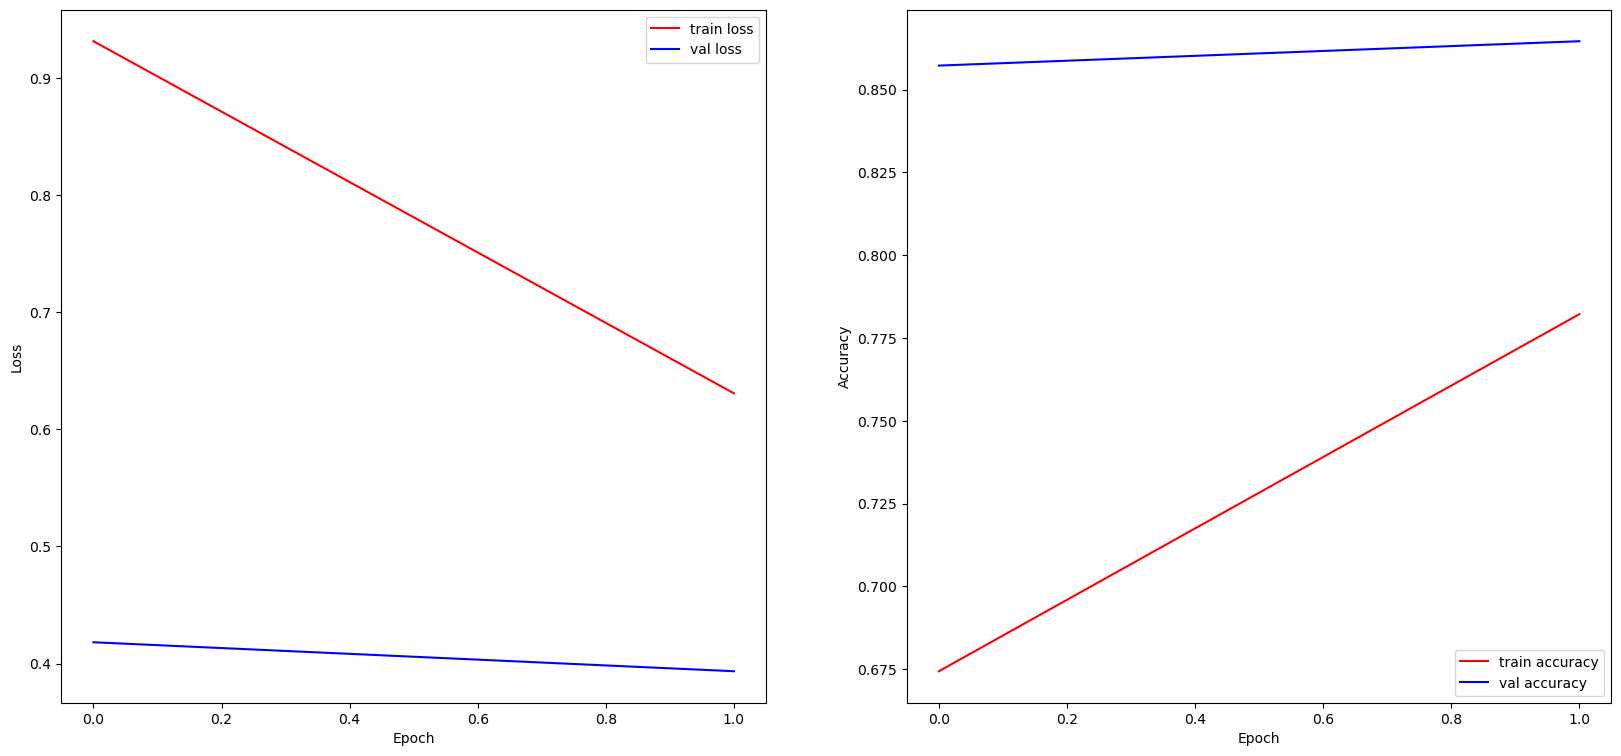

In [31]:
plot_history(history1)

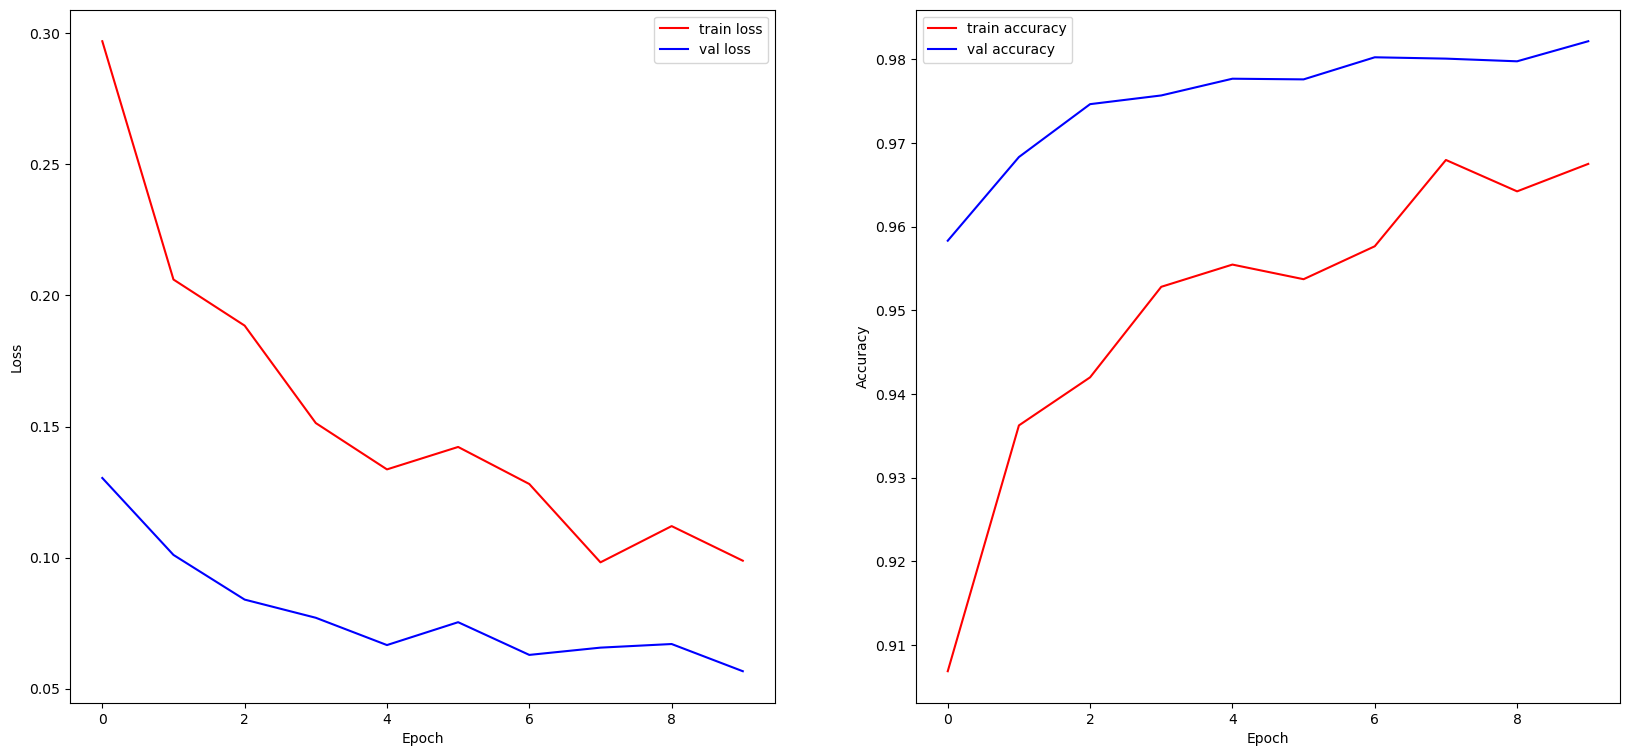

In [32]:
plot_history(history)

In [33]:
# fine-tuning accuracy/time: 40~60 min/10 epoch 
# vit-b16: test accuracy - 98.1~4%, 
# sgd(0.01,0.9)-sgd(0.001,0.9), 98.1%, 3476 sec

## 2.4 Evaluation
### Quantitative Evaluation

In [34]:
predictions = model.predict(x_test)
print("\nTest Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)))

313/313 [==============================] - 49s 148ms/step

Test Accuracy:  0.9808


### Generate Confusion Matrix

In [35]:
# Generate predictions for the test dataset.
predictions = model.predict(x_test)

# For each sample image in the test dataset, select the class label with the highest probability.
predicted_labels = [np.argmax(i) for i in predictions]

313/313 [==============================] - 46s 147ms/step


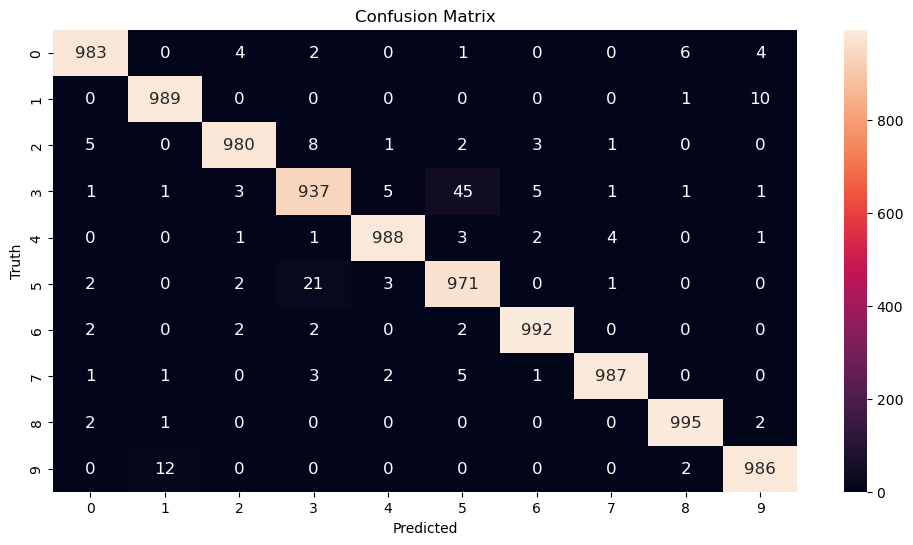

In [36]:
# Convert one-hot encoded labels to integers.
y_test_integer_labels = tf.argmax(y_test, axis=1)

# Generate a confusion matrix for the test dataset.
cm = tf.math.confusion_matrix(labels=y_test_integer_labels, predictions=predicted_labels)

# Plot the confusion matrix as a heatmap.
plt.figure(figsize=[12, 6])
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 12})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Qualitative Evaluation

In [37]:
def evaluate_model(x_dataset, y_label, model):

    class_names = ['airplane',
                   'automobile',
                   'bird',
                   'cat',
                   'deer',
                   'dog',
                   'frog',
                   'horse',
                   'ship',
                   'truck' ]
    num_rows = 3
    num_cols = 6
    
    # Retrieve a number of images from the dataset.
    data_batch = x_dataset[0:num_rows*num_cols]

    # Get predictions from model.  
    predictions = model.predict(data_batch)

    plt.figure(figsize=(20, 8))
    num_matches = 0
        
    for idx in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.axis("off")
        plt.imshow(data_batch[idx])

        pred_idx = tf.argmax(predictions[idx]).numpy()
        truth_idx = np.nonzero(y_label[idx])
            
        title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
        title_obj = plt.title(title, fontdict={'fontsize':13})
            
        if pred_idx == truth_idx:
            num_matches += 1
            plt.setp(title_obj, color='g')
        else:
            plt.setp(title_obj, color='r')
                
        acc = num_matches/(idx+1)
    print("Prediction accuracy: ", int(100*acc)/100)
    
    return


1/1 [==============================] - 0s 124ms/step
Prediction accuracy:  1.0


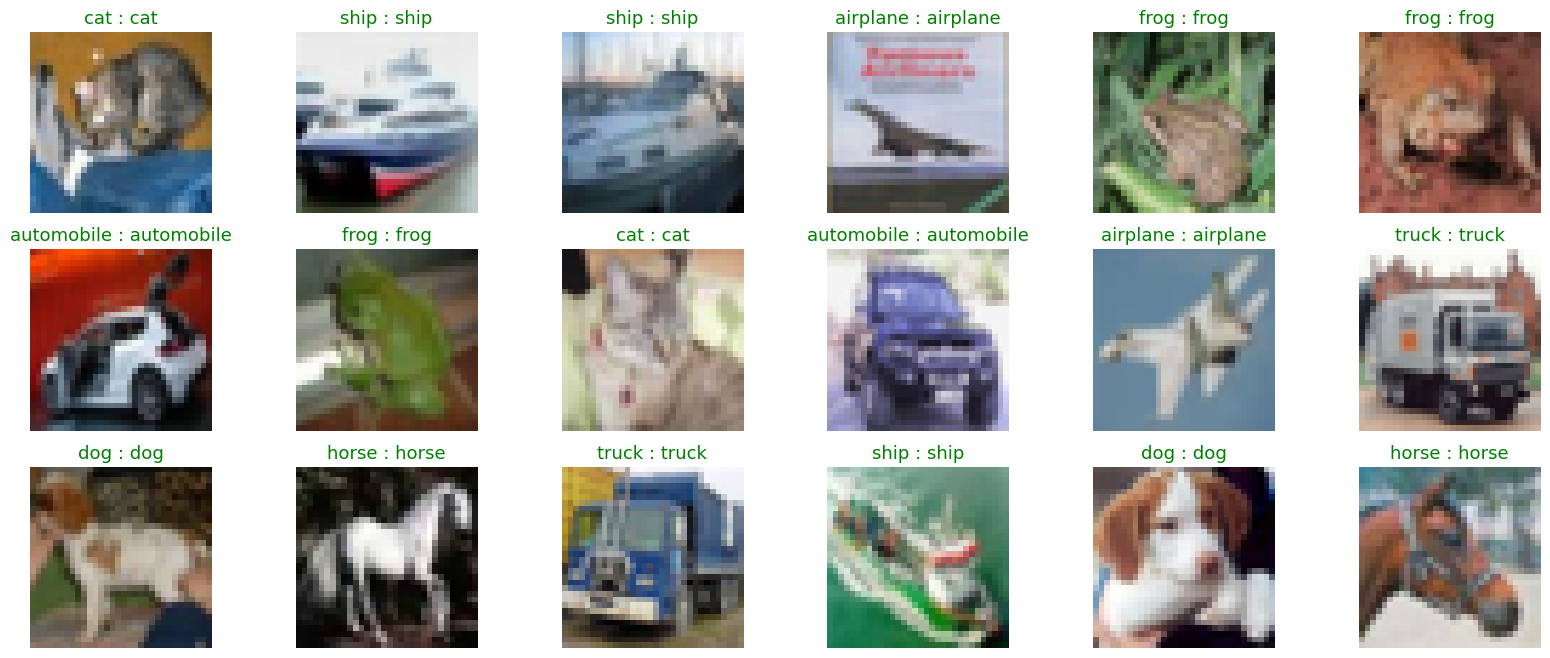

In [38]:
evaluate_model(x_test, y_test, model)

## Inference test

In [39]:
cifar10_categories=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

1/1 [==============================] - 0s 68ms/step
ground truth_label = cat, predicted_label = cat
Similarity = 0.9938964247703552


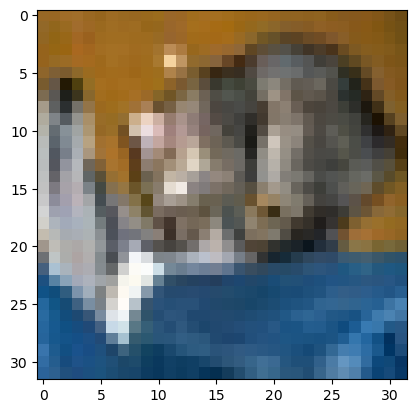

In [40]:
## Run inference on new data
# save an image from cifar10 dataset and load it
image_id = 0 # cifar10 test image id in number
image_file = f'./cifar10_test{image_id}.png'
keras.utils.save_img(image_file, x_test[image_id])
img = keras.utils.load_img(image_file, target_size=(32,32))

# image display
plt.imshow(img)
img_array = keras.utils.img_to_array(img)

# add a dimension to make an array ( a form of a list of images) for model.predict input
# [image1]
img_array = np.expand_dims(img_array, axis=0)

# preprocessing the input image  
img_array = img_array.astype('float32') / 255

predictions = model.predict(img_array)
#score = predictions[0]

prediction = np.argmax(predictions[0]) # predicted class id : id for max scores

# categories[prediction]
print(f"ground truth_label = {cifar10_categories[np.argmax(y_test[image_id])]}, predicted_label = {cifar10_categories[prediction]}")
print(f"Similarity = {np.dot(predictions[0],y_test[image_id])}")

In [41]:
# https://github.com/tensorflow/tensorflow/issues/59694
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR) # to ignore tracing functions warning messages


In [42]:
start_time = time.time()

# model save
model_file = 'c:\\tmp\\cifar10_%s' % model_type
# Using the save() method, the model will be saved to the file system in the 'tf SavedModel' format 
# or .'h5'.
model.save(model_file) # tf format
# model.save('%s.h5' % model_file) # h5 : does not work

end_time = time.time()
print(f"time to save the model = {end_time-start_time:.2f} sec") #

INFO:tensorflow:Assets written to: c:\tmp\cifar10_vit_b16\assets


INFO:tensorflow:Assets written to: c:\tmp\cifar10_vit_b16\assets


time to save the model = 62.61 sec


In [43]:
if sys.platform == 'win32':
    !dir {model_file}  /b
else:
    !ls {model_file}

assets
keras_metadata.pb
saved_model.pb
variables


In [44]:
start_time = time.time()
# check the saved model whether it can be loaded 
reloaded_model = keras.models.load_model(model_file)
reloaded_model.summary()

end_time = time.time()
print(f"time to load the model = {end_time-start_time:.2f} sec") #

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                                 
 feature (Activation)        (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 85,823,594
Trainable params: 85,823,594
Non-t